<span style="font-family: Palatino; font-size: 40px; color: purple">
             Homework - build toy trading system 
</span>


Copyright (c) 2022 RM Stein and Jiayuan Song.

This version: 11-15-2022

<span style="color:purple; font-size:30px">
    <b>Background</b>
</span>

## <span style="color:purple"> 0.1 Business context </span>

__You are back on the trading desk, working with the trader from HW02.  The trader is now interested in exploring whether you can use your expert knowledge of data science work to improve your predictions by including some technical indicators that traders use, instead of just using the raw variables used in HW02. But this time she is interested in trading silver. She asks you to mine (ha ha!) some silver data to come up with a model that she can use for trading silver futures.__

__This time, instead of simply evaluating how accurate your directional predictions are,  the trader would like to get a more realistic sense of how the model would perform if she were to actually trade it.  She asks you to show how your model  gets turned into a trading system, and to show how the system would have performed over the past year.  She now requires that you to you perform a basic *backtest* of the rules you discover.__


## <span style="color:purple"> 0.2 ** Mandate </span>

You are being asked to build four candidate models, to convert these into trading signal generators, and to backtest these on historical data and out-of-sample data.  

## <span style="color:purple"> 0.3 Requirements</span>

* Packages: 
    * Please use the `talib` package (installation following [talib installation](https://pypi.org/project/TA-Lib/)) to create your market indicators. 
    * Please use the `bt` package (installation following [bt installation](https://pmorissette.github.io/bt/install.html)) to perform your backtesting.  
* Dataset: 
    * Please use the raw data named 'HW04_silver_CM_sorted.csv' (under "Homework 04" on Brightspace) for your modeling and backtests. 
    * Please treat any data in the year of 2022 as out-of-sample, and any data before the year of 2022 as in-sample. 
* Please assume that you will know the prior trading day's closing price before the next day's market open. 
* Please ignore the effects of weekends and holidays on the returns and volatities.
* Please assume a 365 day convention for anualization if you require it.

## <span style="color:purple">0.4 Imports</span>

In [2362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
import bt
import talib

In [2363]:
data = pd.read_csv("HW04_silver_CM_sorted.csv")

## 0.5 <span style="color:purple"> Helper functions and class definitions</span>

### `SelectWhere`

This subclass of `bt.Algo` lets you easily to take an set of (boolean) trading signals in dataframe and pull out the corresponding trading days. It can be used with other Algos to construt a AlgoStack. 

In [2364]:
class SelectWhere(bt.Algo):

    """
    Selects securities where the value is True on the current date (target.now).

    Args:
        * signal: DataFrame containing the signal (boolean DataFrame)


    """
    def __init__(self, signal):
        self.signal = signal
        
    # - - - - - - - - - -

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index: 
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected  

        # return True because we want to keep on moving down the stack
        return True


<span style="color:purple; font-size:30px">
    <b>1. Data Understanding, Data Prep and Transformations </b>
</span>

# <span style="color:purple"> 1.1 Understanding </span>

####  1.1.0.1 Plot the time series of the closing price of silver futures prior to the year of 2022 with appropriate title, axes and readable labelings. 

In [2365]:
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')

In [2366]:
in_sample = data[:1063]
out_of_sample = data[1064:]

In [2367]:
close_price = in_sample["Close"]
dates = in_sample["Date"]

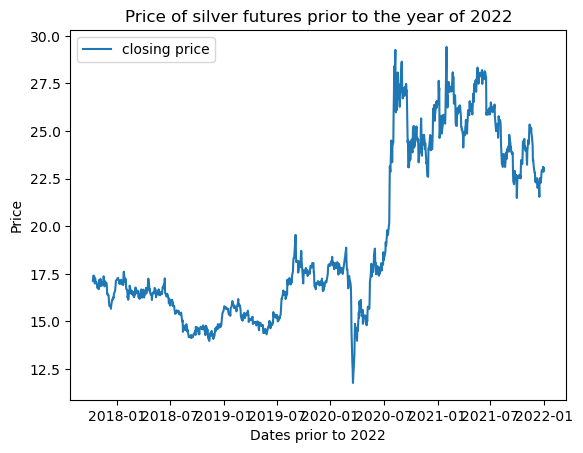

In [2368]:
%matplotlib inline
plt.plot(dates, close_price, label = "closing price")
plt.title("Price of silver futures prior to the year of 2022")
plt.xlabel("Dates prior to 2022")
plt.legend()
plt.ylabel("Price")
plt.show()

#### 1.1.0.2 What do you observe in the trend of the prices? Are there any steep increase of decrease? If so, around which time did they occur? 

There is a huge drop in the price of silver in 2020. But it makes a huge jump and increases after a short period of time. This implies that the price was volatile. Around 2021, this huge increase reaches it's peak.

# <span style="color:purple"> 1.2 Preprocessing </span> 

## 1.2.1 Dependent variable (target feature)

#### 1.2.1.1 Please create a new column in your dataframe for the log returns of the `Close` (price) in the data. 

In [2369]:
data["Log_Return"] = (np.log(data["Close"]/data["Close"].shift(1)))

In [2370]:
data.head()

,Date,Open,High,Low,Close,Log_Return
0,2017-10-11,17.150,17.265,17.085,17.133,NaN
1,2017-10-12,17.190,17.290,17.135,17.266,0.007733
2,2017-10-13,17.275,17.450,17.200,17.411,0.008363
3,2017-10-16,17.425,17.495,17.135,17.369,-0.002415
4,2017-10-17,17.260,17.280,16.985,17.041,-0.019065


#### 1.2.1.2 Please create a new column in your dataframe called `positive_return_dummy` that takes the value `1` if the return for the day is greater than 0 and `0` otherwise.  This will be your dependent variable for data mining. 

In [2371]:
data['positive_return_dummy'] = np.where(data['Log_Return'] > 0, 1, 0)

In [2372]:
data.head()

,Date,Open,High,Low,Close,Log_Return,positive_return_dummy
0,2017-10-11,17.150,17.265,17.085,17.133,NaN,0
1,2017-10-12,17.190,17.290,17.135,17.266,0.007733,1
2,2017-10-13,17.275,17.450,17.200,17.411,0.008363,1
3,2017-10-16,17.425,17.495,17.135,17.369,-0.002415,0
4,2017-10-17,17.260,17.280,16.985,17.041,-0.019065,0


## 1.2.2 Independent variables
In this section, we will calculate and work with several common following technical indicators from the `talib` package: 

### 1.2.2.1 Historical Volatility 

#### 1.2.2.1.1 Please create new columns in your dataframe for historical (return) volatility using windows $[5, 10, 20, 30, 60, 120]$ and add them to your dataframe 

In [2373]:
log = data["Log_Return"]
window = [5,10,20,30,60,120] 
windows = []
for i in window:
    result = talib.STDDEV(log, timeperiod=i)
    windows.append(result)

In [2374]:
data["return_vol_5"] = windows[0]
data["return_vol_10"] = windows[1]
data["return_vol_20"] = windows[2]
data["return_vol_30"] = windows[3]
data["return_vol_60"] = windows[4]
data["return_vol_120"] = windows[5]

In [2375]:
data.tail()

,Date,Open,High,Low,Close,Log_Return,positive_return_dummy,return_vol_5,return_vol_10,return_vol_20,return_vol_30,return_vol_60,return_vol_120
1274,2022-11-02,19.230,19.255,19.090,19.594,-0.003719,0,0.015041,0.012609,0.019706,0.024853,0.021422,0.019764
1275,2022-11-03,19.500,19.515,19.455,19.430,-0.008405,0,0.015528,0.012711,0.019659,0.024866,0.021372,0.019749
1276,2022-11-04,20.784,20.965,20.784,20.784,0.067365,1,0.028556,0.022719,0.024526,0.026737,0.022964,0.020557
1277,2022-11-07,20.850,20.945,20.785,20.919,0.006474,1,0.027727,0.022719,0.023311,0.026296,0.022877,0.020548
1278,2022-11-08,21.425,21.540,21.380,21.502,0.027488,1,0.027672,0.023410,0.023774,0.026525,0.022974,0.020685


### 1.2.2.2 SMA (simple moving average):
SMA is the average closing prices within a specified window. 

#### 1.2.2.2.1 Please create new columns in your dataframe for SMA using windows $[5, 10, 20, 30, 60, 120]$. 

In [2376]:
close = data["Close"]
window = [5,10,20,30,60,120] 
windows1 = []
for i in window:
    result = talib.SMA(close, timeperiod=i)
    windows1.append(result)

In [2377]:
data["sma_5"] = windows1[0]
data["sma_10"] = windows1[1]
data["sma_20"] = windows1[2]
data["sma_30"] = windows1[3]
data["sma_60"] = windows1[4]
data["sma_120"] = windows1[5]

In [2378]:
windows_5 = windows1[0]
windows_10 = windows1[1]
windows_30 = windows1[3]
windows_120 = windows1[5]

In [2379]:
data.tail()

,Date,Open,High,Low,Close,Log_Return,positive_return_dummy,return_vol_5,return_vol_10,return_vol_20,return_vol_30,return_vol_60,return_vol_120,sma_5,sma_10,sma_20,sma_30,sma_60,sma_120
1274,2022-11-02,19.230,19.255,19.090,19.594,-0.003719,0,0.015041,0.012609,0.019706,0.024853,0.021422,0.019764,19.4042,19.2800,19.22110,19.287633,19.215950,19.887208
1275,2022-11-03,19.500,19.515,19.455,19.430,-0.008405,0,0.015528,0.012711,0.019659,0.024866,0.021372,0.019749,19.3914,19.3541,19.15960,19.281400,19.194083,19.874117
1276,2022-11-04,20.784,20.965,20.784,20.784,0.067365,1,0.028556,0.022719,0.024526,0.026737,0.022964,0.020557,19.7188,19.5259,19.18605,19.343867,19.201333,19.867725
1277,2022-11-07,20.850,20.945,20.785,20.919,0.006474,1,0.027727,0.022719,0.023311,0.026296,0.022877,0.020548,20.0788,19.6989,19.25125,19.425167,19.205017,19.860800
1278,2022-11-08,21.425,21.540,21.380,21.502,0.027488,1,0.027672,0.023410,0.023774,0.026525,0.022974,0.020685,20.4458,19.9142,19.35200,19.530667,19.225517,19.860450


#### 1.2.2.2.2 Please plot the following time series (before 2022) in two panels with Panel (1)  above Panel (2): (1) the closing prices of silver future; (2) the SMA with windows $5, 30$ and $120$. 

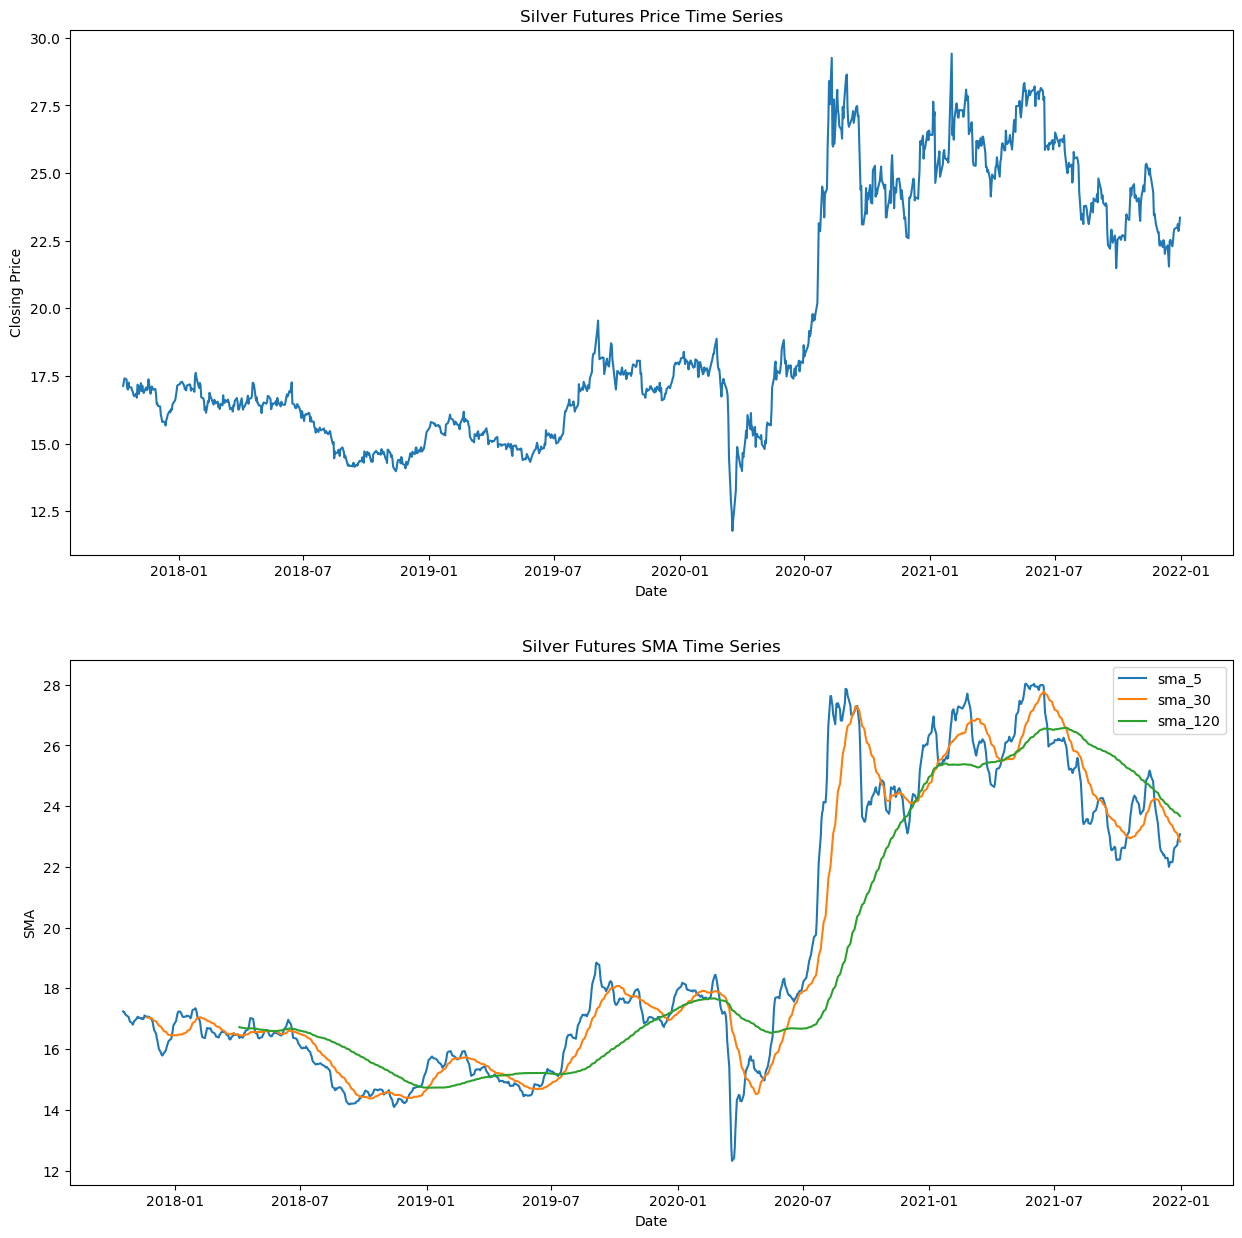

In [2380]:
in_sample = data[data['Date'] < '2022-01-01']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

ax1.plot(in_sample['Date'], in_sample['Close'])
ax1.set_title('Silver Futures Price Time Series')
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price')

ax2.plot(in_sample['Date'], in_sample['sma_5'], label='sma_5')
ax2.plot(in_sample['Date'], in_sample['sma_30'], label='sma_30')
ax2.plot(in_sample['Date'], in_sample['sma_120'], label='sma_120')
ax2.set_title('Silver Futures SMA Time Series')
ax2.set_xlabel('Date')
ax2.set_ylabel('SMA')
ax2.legend()

plt.show()



##### 1.2.2.2.3 What do you notice about about these SMA series? Describe your observations.

SMA is to establish the direction in which the price of a security is moving based on past prices. Since SMA is built using past closing prices, it is a lag indicator. This means that it simply displays a previous trend, but it is not predictive of future prices.

All three windows look similar to one another. Since they look similar, this is an indication that the direction of security price is not much different through the 3 windows. 

Although SMA-120 seems to be smoother than the other 3 windows and the other two seems bumpy suggesting they could be a bit more volatile than SMA 120. 

### 1.2.2.3 EWMA (exponentially weighted moving average): 
EWMA is the weighted moving average that applies more weighting to more recent prices. 

#### 1.2.2.3.1 Please create new columns in your dataframe for EWMA using windows $[5, 10, 20, 30, 60, 120]$. 

In [2381]:
window = [5,10,20,30,60,120]
windows2 = []
for i in window:
    result  = talib.EMA(close, timeperiod=i)
    windows2.append(result)

In [2382]:
data["ewma_5"] = windows2[0]
data["ewma_10"] = windows2[1]
data["ewma_20"] = windows2[2]
data["ewma_30"] = windows2[3]
data["ewma_60"] = windows2[4]
data["ewma_120"] = windows2[5]

In [2383]:
data.tail()

,Date,Open,High,Low,Close,Log_Return,positive_return_dummy,return_vol_5,return_vol_10,return_vol_20,...,sma_20,sma_30,sma_60,sma_120,ewma_5,ewma_10,ewma_20,ewma_30,ewma_60,ewma_120
1274,2022-11-02,19.230,19.255,19.090,19.594,-0.003719,0,0.015041,0.012609,0.019706,...,19.22110,19.287633,19.215950,19.887208,19.437934,19.320930,19.262498,19.255472,19.406310,20.110127
1275,2022-11-03,19.500,19.515,19.455,19.430,-0.008405,0,0.015528,0.012711,0.019659,...,19.15960,19.281400,19.194083,19.874117,19.435289,19.340761,19.278451,19.266732,19.407086,20.098885
1276,2022-11-04,20.784,20.965,20.784,20.784,0.067365,1,0.028556,0.022719,0.024526,...,19.18605,19.343867,19.201333,19.867725,19.884859,19.603168,19.421836,19.364620,19.452231,20.110209
1277,2022-11-07,20.850,20.945,20.785,20.919,0.006474,1,0.027727,0.022719,0.023311,...,19.25125,19.425167,19.205017,19.860800,20.229573,19.842410,19.564423,19.464903,19.500322,20.123578
1278,2022-11-08,21.425,21.540,21.380,21.502,0.027488,1,0.027672,0.023410,0.023774,...,19.35200,19.530667,19.225517,19.860450,20.653715,20.144154,19.748954,19.596328,19.565951,20.146362


#### 1.2.2.3.2 Please plot the window-10 EMA, window-10 SMA and the closing prices from 2020-02-01 to 2020-05-15. 

In [2384]:
windows_10 = windows1[1]
windows2_10 = windows2[1]

In [2385]:
mask = data[(data['Date'] >= '2020-02-01') & (data['Date'] <= '2020-05-15')]


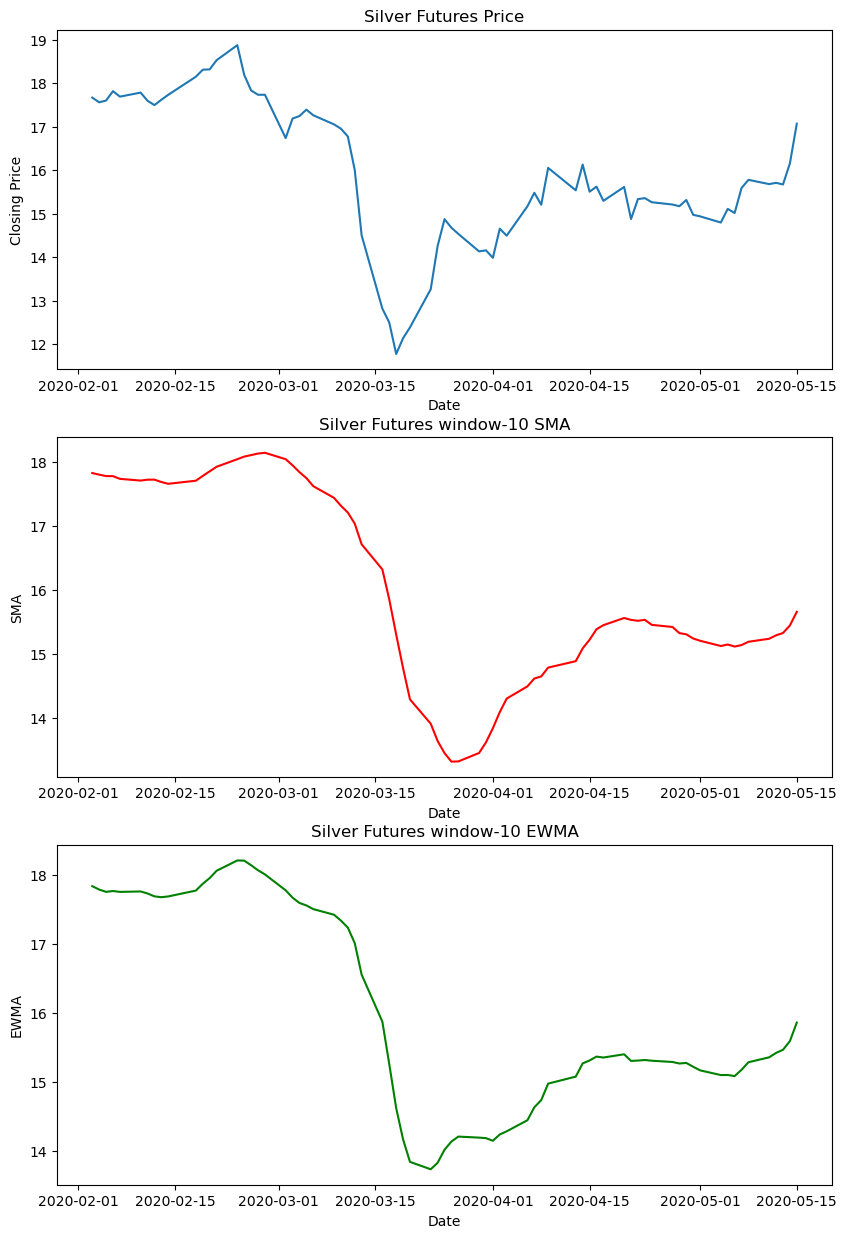

In [2386]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

#Plot the closing price
ax1.plot(mask['Date'], mask['Close'])
ax1.set_title('Silver Futures Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price')

#Plot the 10d SMA
ax2.plot(mask['Date'], mask['sma_10'], color = "red")
ax2.set_title('Silver Futures window-10 SMA')
ax2.set_xlabel('Date')
ax2.set_ylabel('SMA')

#Plot the 10d EMA
ax3.plot(mask['Date'], mask['ewma_10'], color = "green")
ax3.set_title('Silver Futures window-10 EWMA')
ax3.set_xlabel('Date')
ax3.set_ylabel('EWMA')

plt.show()


##### 1.2.2.3.3 What do you observe about the reactions of SMA and EMA to the price decrease in March? Briefly explain the underlying reason to this observation. 

We can see that in the month of march, there is a a huge dip. This means that the security price is decreasing for SMA and EMA 

Calculations make EMA quicker to react to price changes.In the beginning, the prices seem pretty stable/ consistent, but there is a huge dip arond late Feb to early March. However, EWMA seems to be doing a bit better compared to other graphs. Although all three experienced something in March, the overal performance is likely due to the considered 10 day window. 

### 1.2.2.4 MACD (moving average convergence/divergence): 
MACD is a trend-following momentum indicator, which is the difference between a 26-day and 12-day exponential moving average. 

#### 1.2.2.4.1 Please create a new column in your dataframe for MACD. 

In [2387]:
macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26)


In [2388]:
data["macd"] = macd
data["macdsingal"] = macdsignal
data["macdhist"] = macdhist

In [2389]:
data.tail()

,Date,Open,High,Low,Close,Log_Return,positive_return_dummy,return_vol_5,return_vol_10,return_vol_20,...,sma_120,ewma_5,ewma_10,ewma_20,ewma_30,ewma_60,ewma_120,macd,macdsingal,macdhist
1274,2022-11-02,19.230,19.255,19.090,19.594,-0.003719,0,0.015041,0.012609,0.019706,...,19.887208,19.437934,19.320930,19.262498,19.255472,19.406310,20.110127,0.043334,-0.019549,0.062883
1275,2022-11-03,19.500,19.515,19.455,19.430,-0.008405,0,0.015528,0.012711,0.019659,...,19.874117,19.435289,19.340761,19.278451,19.266732,19.407086,20.098885,0.050615,-0.005517,0.056131
1276,2022-11-04,20.784,20.965,20.784,20.784,0.067365,1,0.028556,0.022719,0.024526,...,19.867725,19.884859,19.603168,19.421836,19.364620,19.452231,20.110209,0.163754,0.028337,0.135416
1277,2022-11-07,20.850,20.945,20.785,20.919,0.006474,1,0.027727,0.022719,0.023311,...,19.860800,20.229573,19.842410,19.564423,19.464903,19.500322,20.123578,0.261298,0.074930,0.186369
1278,2022-11-08,21.425,21.540,21.380,21.502,0.027488,1,0.027672,0.023410,0.023774,...,19.860450,20.653715,20.144154,19.748954,19.596328,19.565951,20.146362,0.381252,0.136194,0.245058


#### 1.2.2.4.2 Please print the dates on whihc your system would have bought or sold in the period from 2020-02-01 to 2020-05-15 as suggested by the basic MACD trading rule. 
The basic MACD trading rule is to sell when the MACD falls below its signal line. Similarly, a buy signal occurs when the MACD rises above its signal line. <br> 
(Hint: MACD is calculated using the closing prices.)

In [2390]:
buy = data[data["macd"] > data["macdsingal"]][["Close", "macd", "macdsingal", "Date"]]


In [2391]:
sell = data[data["macd"] < data["macdsingal"]][["Close", "macd", "macdsingal", "Date"]]


In [2392]:
mask = (buy["Date"] >= "2020-02-03") & (buy["Date"] <= "2020-05-15" )

In [2393]:
mask2 = (sell["Date"] >= "2020-02-03") & (sell["Date"] <= "2020-05-15" )

In [2394]:
buy = buy.loc[mask]
sell = sell.loc[mask2]

#### 1.2.2.5 Please plot the following time series (from 2020-02-01 to 2020-05-15) in two panels with Panel (1) above Panel (2): (1) the closing prices of silver future with selling dates in red dots and buying dates in green dots; 2) the MACD with the MACD signal line on top. 

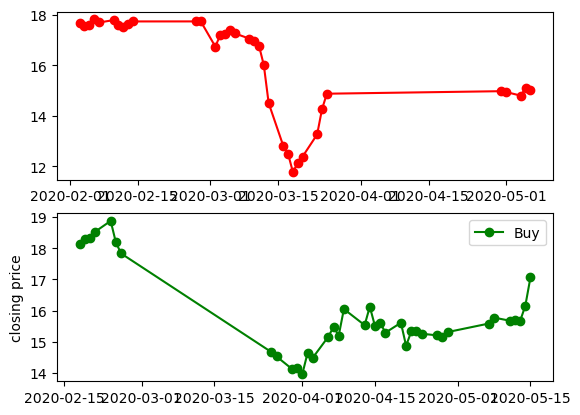

In [2395]:
fig, ax = plt.subplots(2)
ax[0].plot(sell["Date"], sell["Close"], marker = 'o', color = "red", label = "Sell")
ax[1].plot(buy["Date"], buy["Close"], marker='o', color = "green", label = "Buy")
plt.ylabel("closing price")
plt.legend()
plt.show()

### 1.2.2.5 DX (directional movement index): 
DX determines the trend direction of the asset price and the strength of this price movement by comparing the current price with previous lows and highs that lead to positive directional movement (+DI) and negative directional movement (-DI).

#### 1.2.2.5.1 Please create new columns in your dataframe for DX using windows $[5, 10, 20, 30, 60, 120]$. 

In [2396]:
window = [5,10,20,30,60,120]
windows3 = []
for i in window:
    real = talib.DX(high, low, close, timeperiod=i)
    windows3.append(real)


In [2397]:
data["dx_5"] = windows3[0]
data["dx_10"] = windows3[1]
data["dx_20"] = windows3[2]
data["dx_30"] = windows3[3]
data["dx_60"] = windows3[4]
data["dx_120"] = windows3[5]

In [2398]:
data.tail()

,Date,Open,High,Low,Close,Log_Return,positive_return_dummy,return_vol_5,return_vol_10,return_vol_20,...,ewma_120,macd,macdsingal,macdhist,dx_5,dx_10,dx_20,dx_30,dx_60,dx_120
1274,2022-11-02,19.230,19.255,19.090,19.594,-0.003719,0,0.015041,0.012609,0.019706,...,20.110127,0.043334,-0.019549,0.062883,8.766988,7.980343,9.392356,10.331599,11.747334,10.683349
1275,2022-11-03,19.500,19.515,19.455,19.430,-0.008405,0,0.015528,0.012711,0.019659,...,20.098885,0.050615,-0.005517,0.056131,10.195173,1.587200,4.594587,7.066255,10.036665,9.819272
1276,2022-11-04,20.784,20.965,20.784,20.784,0.067365,1,0.028556,0.022719,0.024526,...,20.110209,0.163754,0.028337,0.135416,59.462160,36.468723,16.821279,8.548576,1.246392,5.200601
1277,2022-11-07,20.850,20.945,20.785,20.919,0.006474,1,0.027727,0.022719,0.023311,...,20.123578,0.261298,0.074930,0.186369,59.462160,36.468723,16.821279,8.548576,1.246392,5.200601
1278,2022-11-08,21.425,21.540,21.380,21.502,0.027488,1,0.027672,0.023410,0.023774,...,20.146362,0.381252,0.136194,0.245058,70.010688,46.139818,23.905341,14.052989,2.073416,3.386260


#### 1.2.2.5.2 Please plot the following four time series (before 2022) in four panels: (1) the closing prices of silver future; (2) - (4) the directional movement indices with windows $5, 30$ and $120$. 

In [2399]:
m_2022 = data[data["Date"] <= "2022-01-01"]

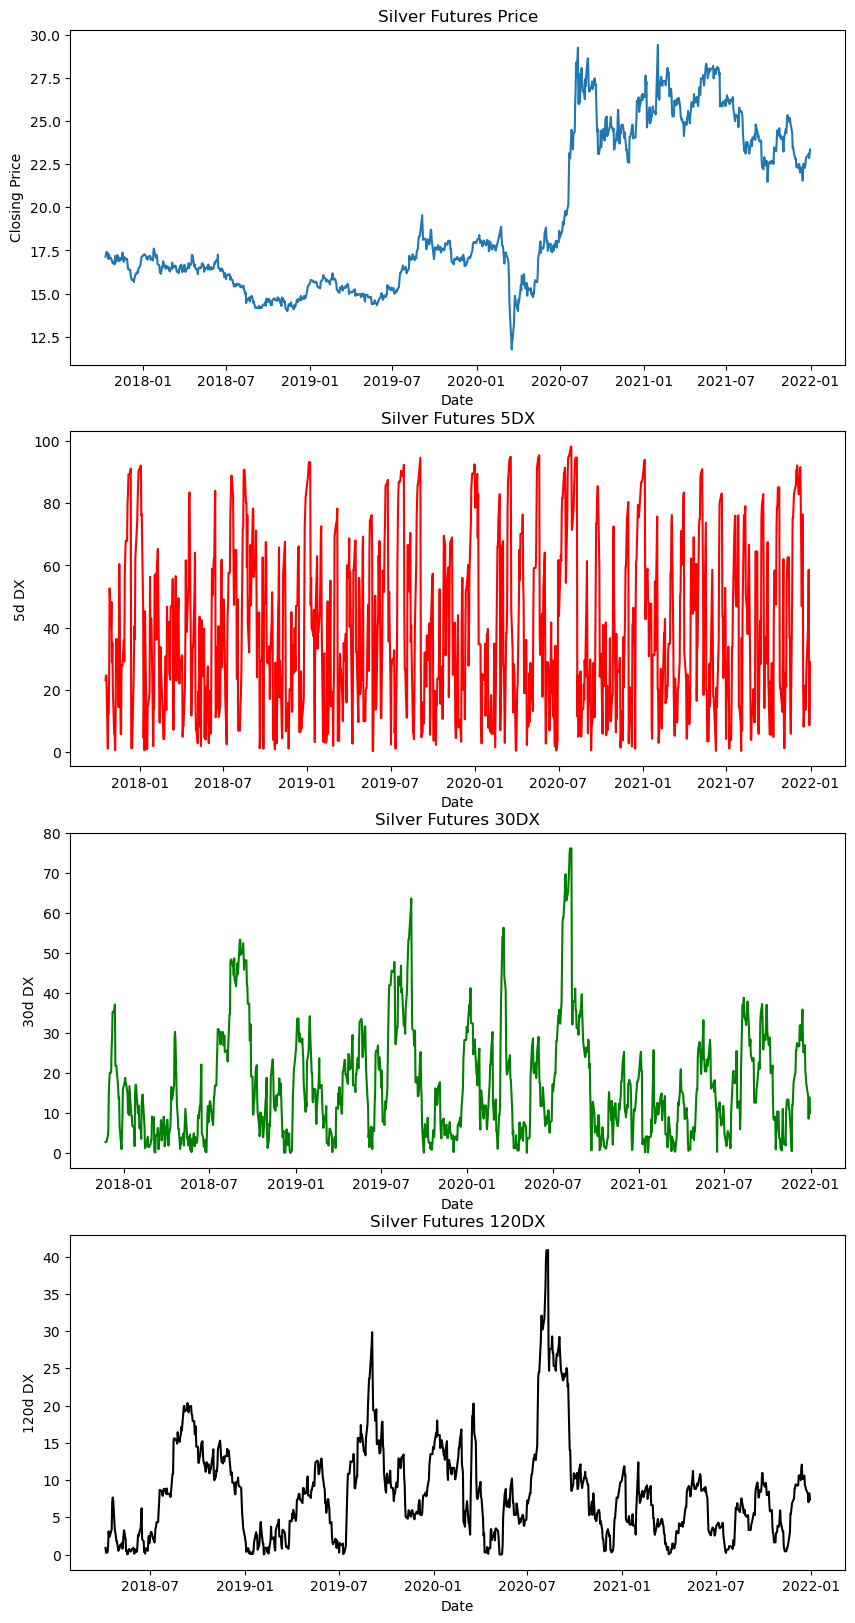

In [2400]:

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 20))

ax1.plot(m_2022['Date'], m_2022['Close'])
ax1.set_title('Silver Futures Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price')

ax2.plot(m_2022['Date'], m_2022['dx_5'], color = "red")
ax2.set_title('Silver Futures 5DX')
ax2.set_xlabel('Date')
ax2.set_ylabel('5d DX')

ax3.plot(m_2022['Date'], m_2022['dx_30'], color = "green")
ax3.set_title('Silver Futures 30DX')
ax3.set_xlabel('Date')
ax3.set_ylabel('30d DX')

ax4.plot(m_2022['Date'], m_2022['dx_120'], color = "black")
ax4.set_title('Silver Futures 120DX')
ax4.set_xlabel('Date')
ax4.set_ylabel('120d DX')

plt.show()

### 1.2.2.6 ADX (average directional movement index): 
ADX is the average of the values of the DX over the specified period. It measures the strength of the trend (regardless of direction) over time.


#### 1.2.2.6.1 Please create new columns in your dataframe for ADX using windows $[5, 10, 20, 30, 60, 120]$. 

In [2401]:
window = [5,10,20,30,60,120]
windows4 = []
for i in window:
    real = talib.ADX(high, low, close, timeperiod=i)
    windows4.append(real)


In [2402]:
data["adx_5"] = windows4[0]
data["adx_10"] = windows4[1]
data["adx_20"] = windows4[2]
data["adx_30"] = windows4[3]
data["adx_60"] = windows4[4]
data["adx_120"] = windows4[5]

In [2403]:
data.tail()

,Date,Open,High,Low,Close,Log_Return,positive_return_dummy,return_vol_5,return_vol_10,return_vol_20,...,dx_20,dx_30,dx_60,dx_120,adx_5,adx_10,adx_20,adx_30,adx_60,adx_120
1274,2022-11-02,19.230,19.255,19.090,19.594,-0.003719,0,0.015041,0.012609,0.019706,...,9.392356,10.331599,11.747334,10.683349,20.773601,15.836958,13.772487,14.253200,13.541278,8.799837
1275,2022-11-03,19.500,19.515,19.455,19.430,-0.008405,0,0.015528,0.012711,0.019659,...,4.594587,7.066255,10.036665,9.819272,18.657916,14.411982,13.313592,14.013635,13.482868,8.808332
1276,2022-11-04,20.784,20.965,20.784,20.784,0.067365,1,0.028556,0.022719,0.024526,...,16.821279,8.548576,1.246392,5.200601,26.818765,16.617656,13.488976,13.831467,13.278927,8.778268
1277,2022-11-07,20.850,20.945,20.785,20.919,0.006474,1,0.027727,0.022719,0.023311,...,16.821279,8.548576,1.246392,5.200601,33.347444,18.602763,13.655591,13.655370,13.078385,8.748454
1278,2022-11-08,21.425,21.540,21.380,21.502,0.027488,1,0.027672,0.023410,0.023774,...,23.905341,14.052989,2.073416,3.386260,40.680092,21.356468,14.168079,13.668624,12.894968,8.703769


## 1.2.3 Time structure

#### 1.2.3.1 Please shift your dependent variable by one day (as we did in previous HWs) so that the values of the independent variables,  $x_{t-1}$ ,  are associated (in the same row as) the values of $y_t$ (the dependent variable). 

In [2404]:

data['positive_return_dummy'] = data['positive_return_dummy'].shift(-1)

In [2405]:
data.tail()

,Date,Open,High,Low,Close,Log_Return,positive_return_dummy,return_vol_5,return_vol_10,return_vol_20,...,dx_20,dx_30,dx_60,dx_120,adx_5,adx_10,adx_20,adx_30,adx_60,adx_120
1274,2022-11-02,19.230,19.255,19.090,19.594,-0.003719,0.0,0.015041,0.012609,0.019706,...,9.392356,10.331599,11.747334,10.683349,20.773601,15.836958,13.772487,14.253200,13.541278,8.799837
1275,2022-11-03,19.500,19.515,19.455,19.430,-0.008405,1.0,0.015528,0.012711,0.019659,...,4.594587,7.066255,10.036665,9.819272,18.657916,14.411982,13.313592,14.013635,13.482868,8.808332
1276,2022-11-04,20.784,20.965,20.784,20.784,0.067365,1.0,0.028556,0.022719,0.024526,...,16.821279,8.548576,1.246392,5.200601,26.818765,16.617656,13.488976,13.831467,13.278927,8.778268
1277,2022-11-07,20.850,20.945,20.785,20.919,0.006474,1.0,0.027727,0.022719,0.023311,...,16.821279,8.548576,1.246392,5.200601,33.347444,18.602763,13.655591,13.655370,13.078385,8.748454
1278,2022-11-08,21.425,21.540,21.380,21.502,0.027488,NaN,0.027672,0.023410,0.023774,...,23.905341,14.052989,2.073416,3.386260,40.680092,21.356468,14.168079,13.668624,12.894968,8.703769


#### 1.2.3.2 Now please relabel all of your independent variables `xxx_L01d`, where `xxx` is the original name of the variable (e.g., `Close` would become `Close_L01d`).  This will help us remember which variables were shifted forward go with which dates (i.e., the `_L01d` suffix reminds us that that varaible represents the value as of the previous trading period.) 

In [2416]:
data = data.rename(columns = lambda col: f"{col}_L01d" 
                                if col not in ('positive_return_dummy') 
                                else col)

In [2417]:
data.tail()

,Date_L01d,Open_L01d,High_L01d,Low_L01d,Close_L01d,Log_Return_L01d,positive_return_dummy,return_vol_5_L01d,return_vol_10_L01d,return_vol_20_L01d,...,dx_20_L01d,dx_30_L01d,dx_60_L01d,dx_120_L01d,adx_5_L01d,adx_10_L01d,adx_20_L01d,adx_30_L01d,adx_60_L01d,adx_120_L01d
1274,2022-11-02,19.230,19.255,19.090,19.594,-0.003719,0.0,0.015041,0.012609,0.019706,...,9.392356,10.331599,11.747334,10.683349,20.773601,15.836958,13.772487,14.253200,13.541278,8.799837
1275,2022-11-03,19.500,19.515,19.455,19.430,-0.008405,1.0,0.015528,0.012711,0.019659,...,4.594587,7.066255,10.036665,9.819272,18.657916,14.411982,13.313592,14.013635,13.482868,8.808332
1276,2022-11-04,20.784,20.965,20.784,20.784,0.067365,1.0,0.028556,0.022719,0.024526,...,16.821279,8.548576,1.246392,5.200601,26.818765,16.617656,13.488976,13.831467,13.278927,8.778268
1277,2022-11-07,20.850,20.945,20.785,20.919,0.006474,1.0,0.027727,0.022719,0.023311,...,16.821279,8.548576,1.246392,5.200601,33.347444,18.602763,13.655591,13.655370,13.078385,8.748454
1278,2022-11-08,21.425,21.540,21.380,21.502,0.027488,NaN,0.027672,0.023410,0.023774,...,23.905341,14.052989,2.073416,3.386260,40.680092,21.356468,14.168079,13.668624,12.894968,8.703769


#### 1.2.3.3 Please print the head of your newly labeled dataframe. Make sure the dataframe only contains valid and useful rows. 

In [2418]:
last_date = data['Date_L01d'].dt.date.astype(str).iloc[-1]
data = data.dropna()

data.head()


,Date_L01d,Open_L01d,High_L01d,Low_L01d,Close_L01d,Log_Return_L01d,positive_return_dummy,return_vol_5_L01d,return_vol_10_L01d,return_vol_20_L01d,...,dx_20_L01d,dx_30_L01d,dx_60_L01d,dx_120_L01d,adx_5_L01d,adx_10_L01d,adx_20_L01d,adx_30_L01d,adx_60_L01d,adx_120_L01d
239,2018-09-24,14.325,14.420,14.220,14.341,-0.001254,1.0,0.003373,0.005048,0.007942,...,35.881485,37.310103,28.797288,17.917223,31.377502,45.266917,46.373462,35.474286,16.140366,6.786362
240,2018-09-25,14.295,14.595,14.250,14.493,0.010543,0.0,0.004056,0.005642,0.008279,...,21.669577,28.130242,24.776605,16.159252,37.603560,41.792218,45.138267,35.229484,16.284303,6.864470
241,2018-09-26,14.500,14.545,14.340,14.401,-0.006368,0.0,0.005591,0.005591,0.008297,...,21.669577,28.130242,24.776605,16.159252,42.584407,38.664988,43.964833,34.992843,16.425842,6.941926
242,2018-09-27,14.375,14.480,14.195,14.290,-0.007738,1.0,0.006740,0.006044,0.008374,...,28.532130,32.152273,26.736396,17.199332,34.285022,35.822630,43.193198,34.898157,16.597684,7.027405
243,2018-09-28,14.270,14.755,14.255,14.712,0.029103,0.0,0.013727,0.010028,0.010121,...,9.398113,19.077970,20.672801,14.483191,36.994259,34.342602,41.503444,34.370818,16.665603,7.089536


# <span style="color:purple"> 1.2 Building some basic to toy models </span> 

##  1.2.1 Take 1 - kitchen sink - linear model

#### 1.2.1.1 Please estimate a logit model using the silver data, in which the dependent variable is `positive_return_dummy` and your lagged variables are _all_ of the variables from 1.1.2, and print the summary of the model.  

(Hint, you will find it much easier to do linear model analysis if you use `statsmodels.api.formula` version of the API.)

In [2419]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2420]:
train = data[data['Date_L01d'].dt.date.astype(str) < '2021-12-31']
test = data[data['Date_L01d'].dt.date.astype(str) >= '2021-12-31']


last_date_val = test['Date_L01d'].dt.date.astype(str).iloc[-1]
train1 = train.iloc[:int(.85*len(train))].dropna()
val = train.iloc[int(.85*len(train)):].dropna()

In [2421]:
feat1.columns

Index(['return_vol_5_L01d', 'return_vol_10_L01d', 'return_vol_20_L01d',
       'return_vol_30_L01d', 'return_vol_60_L01d', 'return_vol_120_L01d',
       'sma_5_L01d', 'sma_10_L01d', 'sma_20_L01d', 'sma_30_L01d',
       'sma_60_L01d', 'sma_120_L01d', 'ewma_5_L01d', 'ewma_10_L01d',
       'ewma_20_L01d', 'ewma_30_L01d', 'ewma_60_L01d', 'ewma_120_L01d',
       'macd_L01d', 'macdsingal_L01d', 'macdhist_L01d', 'dx_5_L01d',
       'dx_10_L01d', 'dx_20_L01d', 'dx_30_L01d', 'dx_60_L01d', 'dx_120_L01d',
       'adx_5_L01d', 'adx_10_L01d', 'adx_20_L01d', 'adx_30_L01d',
       'adx_60_L01d', 'adx_120_L01d'],
      dtype='object')

In [2422]:
X1 = train1[['return_vol_5_L01d', 'return_vol_10_L01d', 'return_vol_20_L01d',
       'return_vol_30_L01d', 'return_vol_60_L01d', 'return_vol_120_L01d',
       'sma_5_L01d', 'sma_10_L01d', 'sma_20_L01d', 'sma_30_L01d',
       'sma_60_L01d', 'sma_120_L01d', 'ewma_5_L01d', 'ewma_10_L01d',
       'ewma_20_L01d', 'ewma_30_L01d', 'ewma_60_L01d', 'ewma_120_L01d',
       'macd_L01d', 'macdsingal_L01d', 'macdhist_L01d', 'dx_5_L01d',
       'dx_10_L01d', 'dx_20_L01d', 'dx_30_L01d', 'dx_60_L01d', 'dx_120_L01d',
       'adx_5_L01d', 'adx_10_L01d', 'adx_20_L01d', 'adx_30_L01d',
       'adx_60_L01d', 'adx_120_L01d']]
Y1 = train1['positive_return_dummy']

In [2423]:
log_reg = sm.Logit(Y1, X1)
result = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.657737
         Iterations 13


In [2424]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: Logit
====================================================================================
Model:                   Logit                      Pseudo R-squared:      0.048    
Dependent Variable:      positive_return_dummy      AIC:                   986.8312 
Date:                    2022-12-05 16:06           BIC:                   1137.0168
No. Observations:        700                        Log-Likelihood:        -460.42  
Df Model:                32                         LL-Null:               -483.42  
Df Residuals:            667                        LLR p-value:           0.051994 
Converged:               1.0000                     Scale:                 1.0000   
No. Iterations:          13.0000                                                    
------------------------------------------------------------------------------------
                      Coef.     Std.Err.      z    P>|z|      [0.025       0.975]   
------------------------------------------------------------------------------------
return_vol_5_L01d     22.9810      13.8198  1.6629 0.0963       -4.1054      50.0674
return_vol_10_L01d   -57.1688      19.5752 -2.9205 0.0035      -95.5355     -18.8022
return_vol_20_L01d    12.8424      28.5919  0.4492 0.6533      -43.1967      68.8816
return_vol_30_L01d     4.6595      32.3428  0.1441 0.8854      -58.7311      68.0502
return_vol_60_L01d    -1.6691      35.1498 -0.0475 0.9621      -70.5615      67.2232
return_vol_120_L01d   77.3100      46.7744  1.6528 0.0984      -14.3661     168.9860
sma_5_L01d             1.3777       1.7392  0.7922 0.4282       -2.0309       4.7864
sma_10_L01d            3.2207       1.8667  1.7253 0.0845       -0.4380       6.8793
sma_20_L01d           -1.1052       2.0056 -0.5510 0.5816       -5.0360       2.8257
sma_30_L01d            0.7643       2.4886  0.3071 0.7588       -4.1134       5.6419
sma_60_L01d            0.3304       1.3855  0.2385 0.8115       -2.3851       3.0458
sma_120_L01d           0.9759       0.9269  1.0529 0.2924       -0.8408       2.7927
ewma_5_L01d           -8.0347      17.0255 -0.4719 0.6370      -41.4041      25.3347
ewma_10_L01d        -477.8969     523.9978 -0.9120 0.3618    -1504.9137     549.1198
ewma_20_L01d         208.5166     288.2841  0.7233 0.4695     -356.5098     773.5430
ewma_30_L01d         288.2975     285.5504  1.0096 0.3127     -271.3710     847.9660
ewma_60_L01d         -18.3254      18.1974 -1.0070 0.3139      -53.9916      17.3408
ewma_120_L01d          1.8776       2.1881  0.8581 0.3908       -2.4109       6.1661
macd_L01d            395.1402 5076117.5581  0.0001 0.9999 -9948612.4550 9949402.7353
macdsingal_L01d      124.5305 5076117.7231  0.0000 1.0000 -9948883.3881 9949132.4491
macdhist_L01d        270.6098 5076117.7895  0.0001 1.0000 -9948737.4389 9949278.6586
dx_5_L01d              0.0094       0.0079  1.1813 0.2375       -0.0062       0.0249
dx_10_L01d            -0.0161       0.0192 -0.8406 0.4006       -0.0536       0.0214
dx_20_L01d            -0.0556       0.0480 -1.1578 0.2469       -0.1497       0.0385
dx_30_L01d             0.1178       0.0598  1.9692 0.0489        0.0006       0.2351
dx_60_L01d            -0.1265       0.0643 -1.9680 0.0491       -0.2524      -0.0005
dx_120_L01d            0.1043       0.0515  2.0264 0.0427        0.0034       0.2052
adx_5_L01d            -0.0002       0.0161 -0.0154 0.9877       -0.0318       0.0313
adx_10_L01d            0.0317       0.0385  0.8240 0.4099       -0.0437       0.1071
adx_20_L01d            0.0461       0.1174  0.3927 0.6945       -0.1841       0.2763
adx_30_L01d           -0.1379       0.1838 -0.7501 0.4532       -0.4980       0.2223
adx_60_L01d            0.1993       0.2487  0.8013 0.4229       -0.2882       0.6868
adx_120_L01d          -0.3308       0.3414 -0.9690 0.3326       -0.9998       0.3383
============================================================================

#### 1.2.1.2 Analyze the estimates of the model based on the output of 1.2.1.1

(Hint: evaluate both the coefficients and the marginal effects.  Do you notice anything about the coefficients on similar variables like `SMA_05` and `SMA_10`? Why?)

In [2425]:
result.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
         Logit Marginal Effects         
========================================
Dep. Variable:     positive_return_dummy
Method:                             dydx
At:                              overall
=======================================================================================
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
return_vol_5_L01d       5.3529      3.196      1.675      0.094      -0.911      11.617
return_vol_10_L01d    -13.3161      4.455     -2.989      0.003     -22.048      -4.584
return_vol_20_L01d      2.9913      6.656      0.449      0.653     -10.054      16.037
return_vol_30_L01d      1.0853      7.533      0.144      0.885     -13.679      15.850
return_vol_60_L01d     -0.3888      8.187     -0.047      0.962     -16.436      15.658
return_vol_120_L01d    18.0075     10.816      1.665      0.096      -3.191      39.206
sma_5_L01d              0.3209      0.404      0.794      0.427      -0.472       1.114
sma_10_L01d             0.7502      0.431      1.739      0.082      -0.095       1.596
sma_20_L01d            -0.2574      0.467     -0.551      0.581      -1.172       0.657
sma_30_L01d             0.1780      0.580      0.307      0.759      -0.958       1.314
sma_60_L01d             0.0770      0.323      0.238      0.811      -0.555       0.709
sma_120_L01d            0.2273      0.215      1.056      0.291      -0.195       0.649
ewma_5_L01d            -1.8715      3.963     -0.472      0.637      -9.639       5.896
ewma_10_L01d         -111.3145    121.775     -0.914      0.361    -349.989     127.360
ewma_20_L01d           48.5689     67.053      0.724      0.469     -82.853     179.991
ewma_30_L01d           67.1519     66.326      1.012      0.311     -62.844     197.148
ewma_60_L01d           -4.2685      4.227     -1.010      0.313     -12.553       4.016
ewma_120_L01d           0.4373      0.509      0.860      0.390      -0.560       1.434
macd_L01d              92.0383   1.18e+06   7.78e-05      1.000   -2.32e+06    2.32e+06
macdsingal_L01d        29.0064   1.18e+06   2.45e-05      1.000   -2.32e+06    2.32e+06
macdhist_L01d          63.0320   1.18e+06   5.33e-05      1.000   -2.32e+06    2.32e+06
dx_5_L01d               0.0022      0.002      1.186      0.236      -0.001       0.006
dx_10_L01d             -0.0037      0.004     -0.842      0.400      -0.012       0.005
dx_20_L01d             -0.0129      0.011     -1.162      0.245      -0.035       0.009
dx_30_L01d              0.0274      0.014      1.990      0.047       0.000       0.054
dx_60_L01d             -0.0295      0.015     -1.989      0.047      -0.058      -0.000
dx_120_L01d             0.0243      0.012      2.050      0.040       0.001       0.048
adx_5_L01d          -5.763e-05      0.004     -0.015      0.988      -0.007       0.007
adx_10_L01d             0.0074      0.009      0.826      0.409      -0.010       0.025
adx_20_L01d             0.0107      0.027      0.393      0.694      -0.043       0.064
adx_30_L01d            -0.0321      0.043     -0.751      0.452      -0.116       0.052
adx_60_L01d             0.0464      0.058      0.803      0.422      -0.067       0.160
adx_120_L01d           -0.0770      0.079     -0.971      0.331      -0.232       0.078
=======================================================================================
"""

The coef of sma 5 and sma 10 seems to be different but not similar or close in values. This could be because there was an influence in the 5 day difference window. This implies that during those windows, there was something like an event that influenced the performance. 

## 1.2.2 Take 2 - Using variable selection

#### 1.2.2.1 Please create four new columns in your dataframe, respectively, with the following indicators using the ratio of the its $20$-window value and $120$-day window value. For example, the SMA variable would be $SMA_{ratio} = \frac{SMA_{20}}{SMA_{120}}$.
* historical volatility
* MA (simple moving average)
* ADX (average directional movement index)
* DX (directional movement index) 

In [2426]:
train1['ratio_vol_L01d'] = train1['return_vol_20_L01d']/train1['return_vol_120_L01d']
train1['ratio_sma_L01d'] = train1['sma_20_L01d']/train1['sma_120_L01d']
train1['ratio_adx_L01d'] = train1['adx_20_L01d']/train1['adx_120_L01d']
train1['ratio_dx_L01d'] = train1['dx_20_L01d']/train1['dx_120_L01d']

val['ratio_vol_L01d'] = val['return_vol_20_L01d']/val['return_vol_120_L01d']
val['ratio_sma_L01d'] = val['sma_20_L01d']/val['sma_120_L01d']
val['ratio_adx_L01d'] = val['adx_20_L01d']/val['adx_120_L01d']
val['ratio_dx_L01d'] = val['dx_20_L01d']/val['dx_120_L01d']



#### 1.2.2.2 Now estimate a linear model using the four new varialbes, the values of the four indicators at 10-days window (e.g., `SMA_10`), MACD, along with yesterday's closing price. Print the summary.

In [2427]:
feat2 = train1[['macd_L01d', 'sma_10_L01d', 'ewma_10_L01d', 'dx_10_L01d', 'adx_10_L01d', 'ratio_vol_L01d', 'ratio_sma_L01d', 'ratio_adx_L01d', 'ratio_dx_L01d', 'Close_L01d']]
feature_cols2 = feat2.columns


In [2428]:
X = train1[feature_cols2]
Y = train1.positive_return_dummy

In [2429]:
linear = sm.OLS(Y, X)
linear_results = linear.fit()

In [2430]:
linear_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     positive_return_dummy   R-squared (uncentered):                   0.539
Model:                               OLS   Adj. R-squared (uncentered):              0.533
Method:                    Least Squares   F-statistic:                              80.79
Date:                   Mon, 05 Dec 2022   Prob (F-statistic):                   3.81e-109
Time:                           16:06:52   Log-Likelihood:                         -503.52
No. Observations:                    700   AIC:                                      1027.
Df Residuals:                        690   BIC:                                      1073.
Df Model:                             10                                                  
Covariance Type:               nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
macd_L01d         -0.1075      0.060     -1.783      0.075      -0.226       0.011
sma_10_L01d        0.1515      0.159      0.954      0.341      -0.160       0.463
ewma_10_L01d      -0.1098      0.196     -0.559      0.576      -0.496       0.276
dx_10_L01d        -0.0003      0.001     -0.269      0.788      -0.003       0.002
adx_10_L01d        0.0051      0.003      1.678      0.094      -0.001       0.011
ratio_vol_L01d    -0.0989      0.067     -1.481      0.139      -0.230       0.032
ratio_sma_L01d     0.5548      0.147      3.774      0.000       0.266       0.843
ratio_adx_L01d    -0.0055      0.027     -0.203      0.839      -0.059       0.048
ratio_dx_L01d     -0.0001      0.000     -0.538      0.591      -0.001       0.000
Close_L01d        -0.0446      0.051     -0.874      0.382      -0.145       0.056
==============================================================================
Omnibus:                     2981.453   Durbin-Watson:                   2.211
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.435
Skew:                          -0.139   Prob(JB):                     1.27e-23
Kurtosis:                       1.119   Cond. No.                     1.16e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 1.2.2.3 Compare your results to those in 1.2.1.2.  Discuss your conclusions briefy.

Looking at the results, ratio_sma_L01d seems to have the biggest coef values indicating that this variable has the most influence in this model. The 10 day windows seem to have a lower coef than the previous model aboove. This could be because the model above suffered from multi-colinearity. 

## 1.2.3 Take 3 - DecisionTree and Random Forest

#### 1.2.3.1 Please use the `silver` data to estimate a tree model and a random forest model.  Use `positive_return_dummy` as the dependent variable and your lagged variables are _all_ of the variables from 1.1.2 and 1.2.2 as your independent variables.  

In [2431]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2432]:
X_train = train1[['Close_L01d', 'return_vol_5_L01d',
       'return_vol_10_L01d', 'return_vol_20_L01d', 'return_vol_30_L01d',
       'return_vol_60_L01d', 'return_vol_120_L01d', 'sma_5_L01d',
       'sma_10_L01d', 'sma_20_L01d', 'sma_30_L01d', 'sma_60_L01d',
       'sma_120_L01d', 'ewma_5_L01d', 'ewma_10_L01d', 'ewma_20_L01d',
       'ewma_30_L01d', 'ewma_60_L01d', 'ewma_120_L01d', 'macd_L01d',
       'macdsingal_L01d', 'macdhist_L01d', 'dx_5_L01d', 'dx_10_L01d',
       'dx_20_L01d', 'dx_30_L01d', 'dx_60_L01d', 'dx_120_L01d', 'adx_5_L01d',
       'adx_10_L01d', 'adx_20_L01d', 'adx_30_L01d', 'adx_60_L01d',
       'adx_120_L01d', 'ratio_vol_L01d', 'ratio_sma_L01d', 'ratio_adx_L01d',
       'ratio_dx_L01d']]
Y_train = train1.positive_return_dummy

In [2433]:
clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X_train, Y_train) 

In [2434]:
# Decision Tree
dectree = DecisionTreeClassifier()
dectree = dectree.fit(X_train, Y_train)

# <span style="color:purple"> 1.3 Validating the models (a teeny bit) </span> 

## 1.3.1 Data prep

#### 1.3.1.1 Please preprocess your test data so that it has the same form as your training data and print the head of the final test dataframe.

In [2435]:
test['ratio_vol_L01d'] = test['return_vol_20_L01d']/test['return_vol_120_L01d']
test['ratio_sma_L01d'] = test['sma_20_L01d']/test['sma_120_L01d']
test['ratio_adx_L01d'] = test['adx_20_L01d']/test['adx_120_L01d']
test['ratio_dx_L01d'] = test['dx_20_L01d']/test['dx_120_L01d']

Y_test = test["positive_return_dummy"]
X_test = test[['Close_L01d', 'return_vol_5_L01d',
       'return_vol_10_L01d', 'return_vol_20_L01d', 'return_vol_30_L01d',
       'return_vol_60_L01d', 'return_vol_120_L01d', 'sma_5_L01d',
       'sma_10_L01d', 'sma_20_L01d', 'sma_30_L01d', 'sma_60_L01d',
       'sma_120_L01d', 'ewma_5_L01d', 'ewma_10_L01d', 'ewma_20_L01d',
       'ewma_30_L01d', 'ewma_60_L01d', 'ewma_120_L01d', 'macd_L01d',
       'macdsingal_L01d', 'macdhist_L01d', 'dx_5_L01d', 'dx_10_L01d',
       'dx_20_L01d', 'dx_30_L01d', 'dx_60_L01d', 'dx_120_L01d', 'adx_5_L01d',
       'adx_10_L01d', 'adx_20_L01d', 'adx_30_L01d', 'adx_60_L01d',
       'adx_120_L01d', 'ratio_vol_L01d', 'ratio_sma_L01d', 'ratio_adx_L01d',
       'ratio_dx_L01d']]


/Users/seonhyeyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/seonhyeyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/seonhyeyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

#### 1.3.1.2 For each model in Section 1.2, please use the `xxx.predict(X)` method to produce a vector of predictions based on the out-of-sample data. Create new dataframes made up of a column of the actual value for the dependent variable, and a column for your model's predictions.  Print the head of the new data frames.

In [2436]:
predict_rf = clf.predict(X_test)
rf_df = pd.DataFrame({"Actual":Y_test, "Predicted":predict_rf})

In [2437]:
# rf_df = rf_df.dropna()
rf_df.head()

,Actual,Predicted
1063,0.0,1.0
1064,1.0,1.0
1065,1.0,0.0
1066,0.0,0.0
1067,1.0,0.0


In [2438]:
predict_dt = dectree.predict(X_test)
dt_df = pd.DataFrame({"Actual": Y_test, "Predicted": predict_dt})

In [2439]:
dt_df.head()

,Actual,Predicted
1063,0.0,1.0
1064,1.0,0.0
1065,1.0,0.0
1066,0.0,1.0
1067,1.0,0.0


#### 1.3.1.3 Calculate the area under the ROC for each model on the test data and print your results. Which model has the best area under the ROC? 

In [2440]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay, confusion_matrix


In [2441]:
tree_fpr, tree_tpr, tree_thresholds = roc_curve(dt_df['Actual'], dt_df['Predicted'])
tree_auc = auc(tree_fpr, tree_tpr)
print('Decision Tree ROC AUC:', tree_auc)

forest_fpr, forest_tpr, forest_thresholds = roc_curve(rf_df['Actual'], rf_df['Predicted'])
forest_auc = auc(forest_fpr, forest_tpr)
print('Random Forest ROC AUC:', forest_auc)

Decision Tree AUC: 0.4882744894427138
Random Forest AUC: 0.46897715472481827


Random forest seems to have a better ROC

<span style="color:purple; font-size:30px">
    <b>2. Backtesting </b>
</span> 

# <span style="color:purple">  2.1 In-Sample Testing </span> 

## 2.1.1 Data Prep

### 2.1.1.1 Creating signals

#### 2.1.1.1.1 Please define new `signal` variables for each set of model _predictions_. Please assume that model predictions > 0.5 have a `signal` value of 1, and that the value is 0 otherwise.  Construct four dataframes (or one dataframe with four columns) and date index, which can be later passed into the `SelectWhere()` function, each column being the boolean `signal` produced by one of the four models, with appropriate column names. Print the head of the dataframes. 
(Note that if we had more information about trading costs and profits, we could estimate the "optimal" cutoff value, but for simplicity, here, we will assume that we can use 0.5.)

In [2442]:
import bt

In [2443]:
x = val[['Close_L01d', 'return_vol_5_L01d',
       'return_vol_10_L01d', 'return_vol_20_L01d', 'return_vol_30_L01d',
       'return_vol_60_L01d', 'return_vol_120_L01d', 'sma_5_L01d',
       'sma_10_L01d', 'sma_20_L01d', 'sma_30_L01d', 'sma_60_L01d',
       'sma_120_L01d', 'ewma_5_L01d', 'ewma_10_L01d', 'ewma_20_L01d',
       'ewma_30_L01d', 'ewma_60_L01d', 'ewma_120_L01d', 'macd_L01d',
       'macdsingal_L01d', 'macdhist_L01d', 'dx_5_L01d', 'dx_10_L01d',
       'dx_20_L01d', 'dx_30_L01d', 'dx_60_L01d', 'dx_120_L01d', 'adx_5_L01d',
       'adx_10_L01d', 'adx_20_L01d', 'adx_30_L01d', 'adx_60_L01d',
       'adx_120_L01d', 'ratio_vol_L01d', 'ratio_sma_L01d', 'ratio_adx_L01d',
       'ratio_dx_L01d']]
y = val["positive_return_dummy"]

In [2444]:
#decision tree, random forest, linear, and logit model prediction.

dt_val = dectree.predict(x)
rf_val = clf.predict(x)
ols = linear_results.predict(val[feature_cols2])
logit = result.predict(val[['return_vol_5_L01d', 'return_vol_10_L01d', 'return_vol_20_L01d',
       'return_vol_30_L01d', 'return_vol_60_L01d', 'return_vol_120_L01d',
       'sma_5_L01d', 'sma_10_L01d', 'sma_20_L01d', 'sma_30_L01d',
       'sma_60_L01d', 'sma_120_L01d', 'ewma_5_L01d', 'ewma_10_L01d',
       'ewma_20_L01d', 'ewma_30_L01d', 'ewma_60_L01d', 'ewma_120_L01d',
       'macd_L01d', 'macdsingal_L01d', 'macdhist_L01d', 'dx_5_L01d',
       'dx_10_L01d', 'dx_20_L01d', 'dx_30_L01d', 'dx_60_L01d', 'dx_120_L01d',
       'adx_5_L01d', 'adx_10_L01d', 'adx_20_L01d', 'adx_30_L01d',
       'adx_60_L01d', 'adx_120_L01d']])

In [2445]:
#defining new signal variables for each set of model predictions.

signal_insample = pd.DataFrame({'tree': np.where(dt_val > 0.5, 1, 0)})
signal_insample['forest'] = np.where(rf_val > 0.5, 1, 0)
signal_insample['linear'] = np.where(ols > 0.5, 1, 0)
signal_insample['logit'] = np.where(logit > 0.5, 1, 0)


In [2446]:
signal_insample['Date'] = np.append(val['Date_L01d'].dt.date.astype(str).values[1:], last_date_val)

signal_insample['Date'] = pd.to_datetime(signal_insample['Date'])

In [2447]:
signal_insample.set_index('Date', inplace=True)

In [2448]:
signal_insample.head()

,tree,forest,linear,logit
Date,,,,
2021-07-08,0,0,1,1
2021-07-09,1,1,1,1
2021-07-12,0,0,1,1
2021-07-13,1,0,1,1
2021-07-14,0,0,1,1


In [2449]:
signal_outsample = pd.DataFrame({'tree': np.where(dt_df['Predicted'] > 0.5, 1, 0)})
signal_outsample['forest'] = np.where(rf_df['Predicted'] > 0.5, 1, 0)


In [2450]:
ols_pred = linear_results.predict(X_test[feature_cols2])
logit_pred = result.predict(X_test[['return_vol_5_L01d', 'return_vol_10_L01d', 'return_vol_20_L01d',
       'return_vol_30_L01d', 'return_vol_60_L01d', 'return_vol_120_L01d',
       'sma_5_L01d', 'sma_10_L01d', 'sma_20_L01d', 'sma_30_L01d',
       'sma_60_L01d', 'sma_120_L01d', 'ewma_5_L01d', 'ewma_10_L01d',
       'ewma_20_L01d', 'ewma_30_L01d', 'ewma_60_L01d', 'ewma_120_L01d',
       'macd_L01d', 'macdsingal_L01d', 'macdhist_L01d', 'dx_5_L01d',
       'dx_10_L01d', 'dx_20_L01d', 'dx_30_L01d', 'dx_60_L01d', 'dx_120_L01d',
       'adx_5_L01d', 'adx_10_L01d', 'adx_20_L01d', 'adx_30_L01d',
       'adx_60_L01d', 'adx_120_L01d']])

signal_outsample['ols'] = np.where(ols_pred > 0.5, 1, 0)
signal_outsample['logit'] = np.where(logit_pred > 0.5, 1, 0)
signal_outsample['Date'] = pd.to_datetime(np.append(test['Date_L01d'].dt.date.astype(str).values[1:], last_date))

signal_outsample.set_index('Date', inplace=True)

signal_outsample.head()

,tree,forest,ols,logit
Date,,,,
2022-01-03,1,1,0,1
2022-01-04,0,1,0,1
2022-01-05,0,0,0,1
2022-01-06,1,0,0,1
2022-01-07,0,0,0,1


### 2.1.1.2 Organizing price data 

#### 2.1.1.2.1 We also need our price data for our backtesting. Please create a new dataframe or four one-column dataframes (within the same time range as the signal dataframe) with four columns of closing prices of silver future, each with a *same* column name of the signal dataframe, and date index. This dataframe will be later passed into `bt.Backtest()`. Print the head of the dataframes. 
(Note: pay careful attention to whether or not we need to lag the closing prices for backtesting)

In [2451]:
close_insample = pd.DataFrame({'tree': val['Close_L01d'], 'forest': val['Close_L01d'], 'linear': val['Close_L01d'], 'logit': val['Close_L01d'], 'Date': np.append(val['Date_L01d'].dt.date.astype(str).values[1:], last_date_val)
})

#convert dates to datetime
close_insample['Date'] = pd.to_datetime(close_insample['Date'])

close_insample.set_index('Date', inplace=True)

close_insample.head()


,tree,forest,linear,logit
Date,,,,
2021-07-08,26.129,26.129,26.129,26.129
2021-07-09,25.987,25.987,25.987,25.987
2021-07-12,26.234,26.234,26.234,26.234
2021-07-13,26.239,26.239,26.239,26.239
2021-07-14,26.140,26.140,26.140,26.140


In [2452]:
close_outsamp_df = pd.DataFrame({'tree': test['Close_L01d'], 'forest': test['Close_L01d'], 'linear': test['Close_L01d'], 'logit': test['Close_L01d'], 'Date': np.append(test['Date_L01d'].dt.date.astype(str).values[1:], last_date)
})

#convert dates to datetime
close_outsamp_df['Date'] = pd.to_datetime(close_outsamp_df['Date'])

close_outsamp_df.set_index('Date', inplace=True)

close_outsamp_df

,tree,forest,linear,logit
Date,,,,
2022-01-03,23.352,23.352,23.352,23.352
2022-01-04,22.810,22.810,22.810,22.810
2022-01-05,23.056,23.056,23.056,23.056
2022-01-06,23.170,23.170,23.170,23.170
2022-01-07,22.190,22.190,22.190,22.190
...,...,...,...,...
2022-11-02,19.667,19.667,19.667,19.667
2022-11-03,19.594,19.594,19.594,19.594
2022-11-04,19.430,19.430,19.430,19.430


## 2.1.2 Individual Backtests
In this section, you will be performing backtesting using the bt package. <br>

`We can perform a backtesting following: ` 
```python 
algo_stack = [SelectWhere(signal), bt.algos.WeighEqually(), bt.algos.Rebalance()]
strategy = bt.Strategy(strategy_name, algo_stack) 
bt_instance = bt.Backtest(strategy, closing_price)
res = bt.run(bt_instance)
``` 

`We can access the statistics of the backtest using `
```python 
res.stats 
``` 

`We can view the equity curve using `
```python 
res.plot() 
``` 
<br>
(Hint: To avoid unexpected bugs, the inputs into `SelectWhere()` and `bt.Backtest()` should be dataframes with the same column names)

#### 2.1.2.1 Using the above functions, please perform in-sample backtests for your four strategies. Plot the equity progression curves for all strategies, with take_1 and take_2 on the same plot, and take_3  and take_4 on the same plot. 

In [2465]:

#tree
algo_stack = [SelectWhere(signal_insample), bt.algos.WeighEqually(), bt.algos.Rebalance()]
strategy_tree = bt.Strategy('tree', algo_stack) 
bt_instance_tree = bt.Backtest(strategy_tree, close_insamp_df)
res_tree = bt.run(bt_instance_tree)


#forest
strategy_forest = bt.Strategy('forest', algo_stack)
bt_instance_forest = bt.Backtest(strategy_forest, close_insamp_df)
res_forest = bt.run(bt_instance_forest)

#linear
strategy_ols = bt.Strategy('linear', algo_stack)
bt_instance_ols = bt.Backtest(strategy_ols, close_insamp_df)
res_ols = bt.run(bt_instance_ols)

#logit
strategy_logit = bt.Strategy('logit', algo_stack)
bt_instance_logit = bt.Backtest(strategy_logit, close_insamp_df)
res_logit = bt.run(bt_instance_logit)

<AxesSubplot:title={'center':'Equity Progression'}>

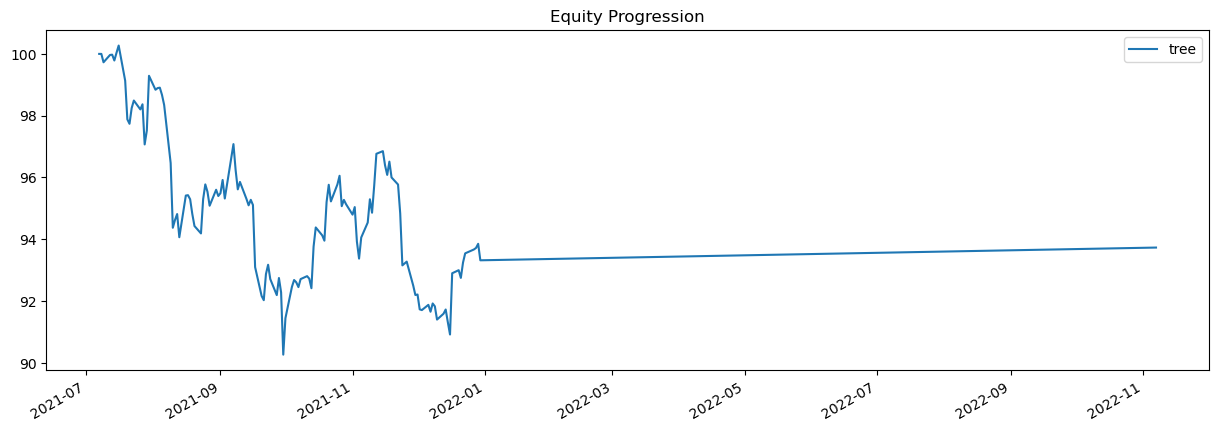

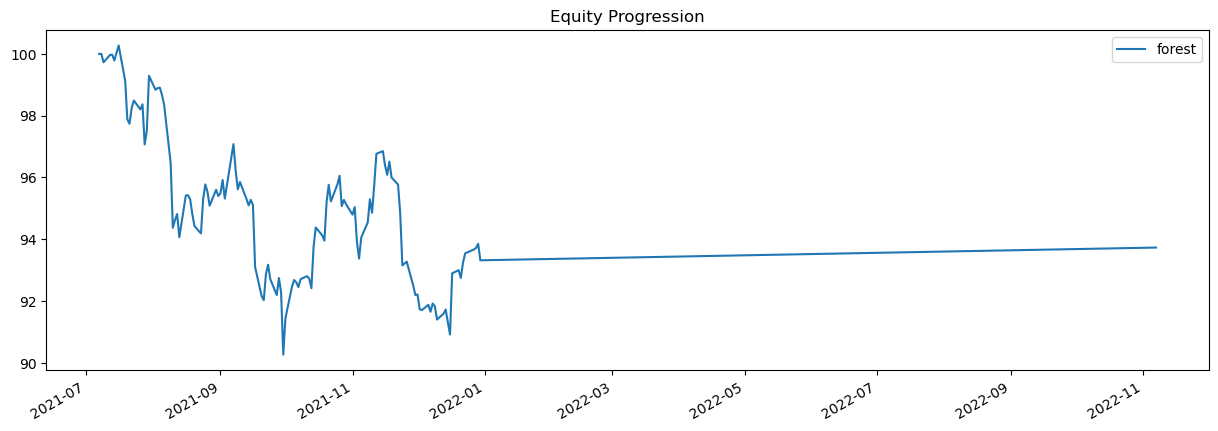

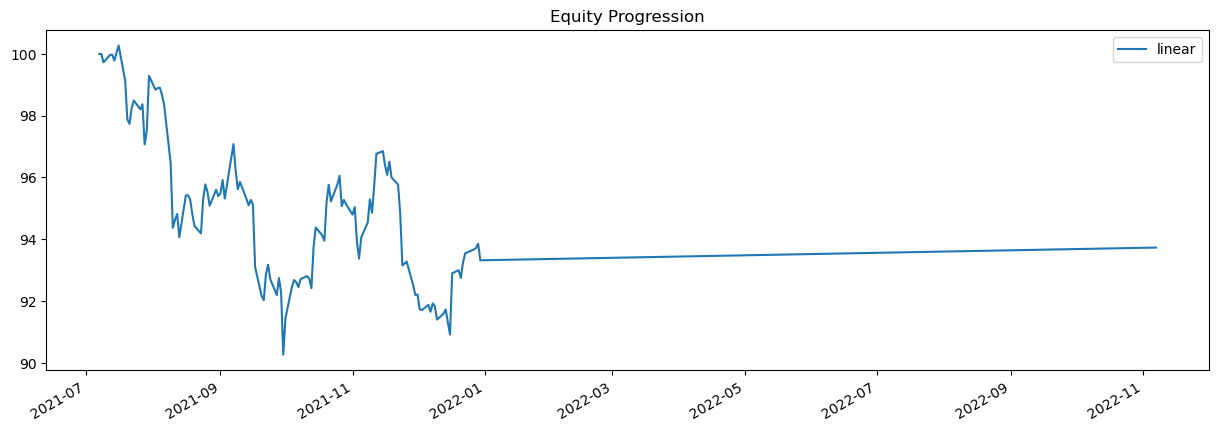

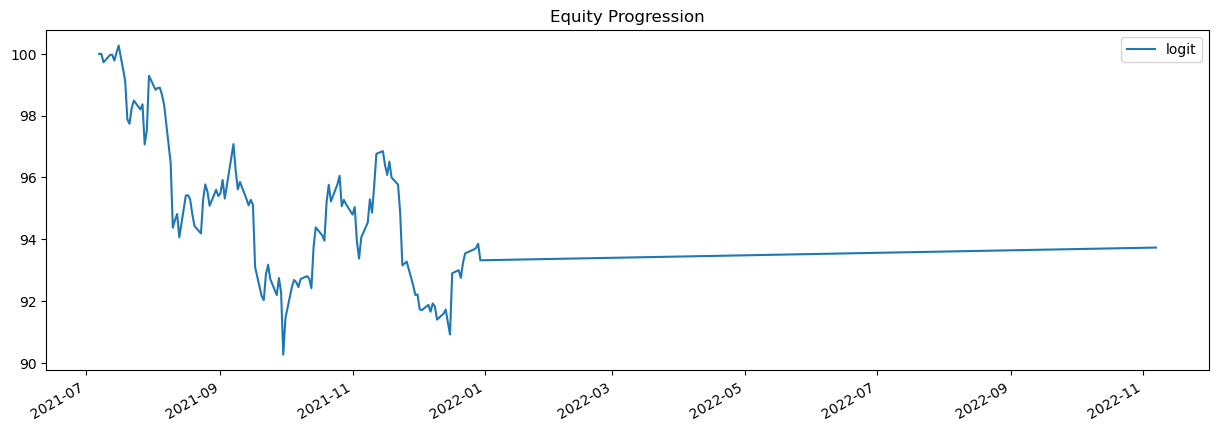

In [2472]:
res_tree.plot()
res_forest.plot()

res_ols.plot()
res_logit.plot()

#### 2.1.2.2 Please display the statistics of the backtests. 

In [2455]:
stat = pd.DataFrame(res_tree.stats)

stat['forest'] = res_forest.stats
stat['ols'] = res_ols.stats
stat['logit'] = res_logit.stats

stat.head()

,tree,forest,ols,logit
start,2021-07-07 00:00:00,2021-07-07 00:00:00,2021-07-07 00:00:00,2021-07-07 00:00:00
end,2022-11-07 00:00:00,2022-11-07 00:00:00,2022-11-07 00:00:00,2022-11-07 00:00:00
rf,0.0,0.0,0.0,0.0
total_return,-0.062703,-0.062703,-0.062703,-0.062703
cagr,-0.047311,-0.047311,-0.047311,-0.047311


#### 2.1.2.3 Write a short paragraph to report and analyze the pregression curves and the statistics. 

# <span style="color:purple">  2.2 Out-of-Sample Testing </span> 

#### 2.2.1 Please backtest your best model using the out-of-sample data, plot the results and stastics. 

<AxesSubplot:title={'center':'Equity Progression'}>

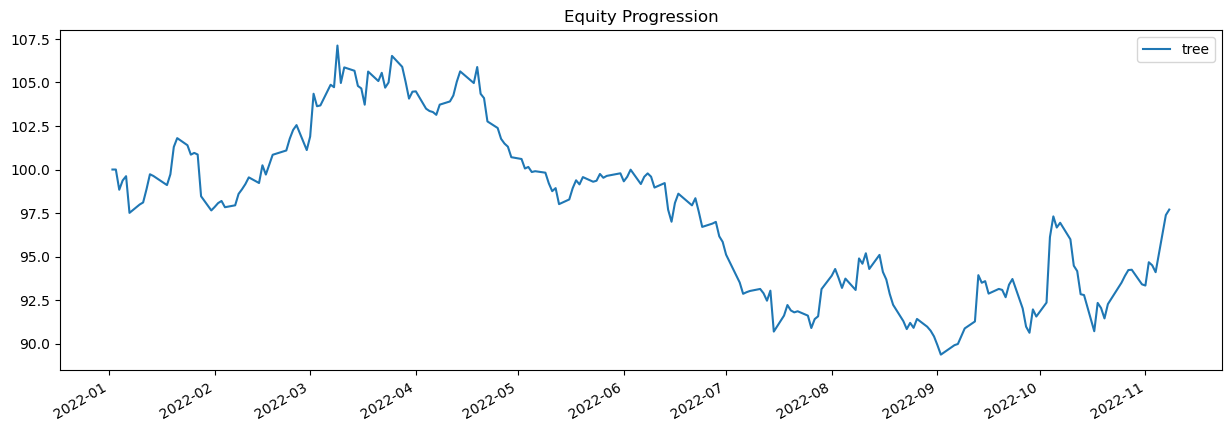

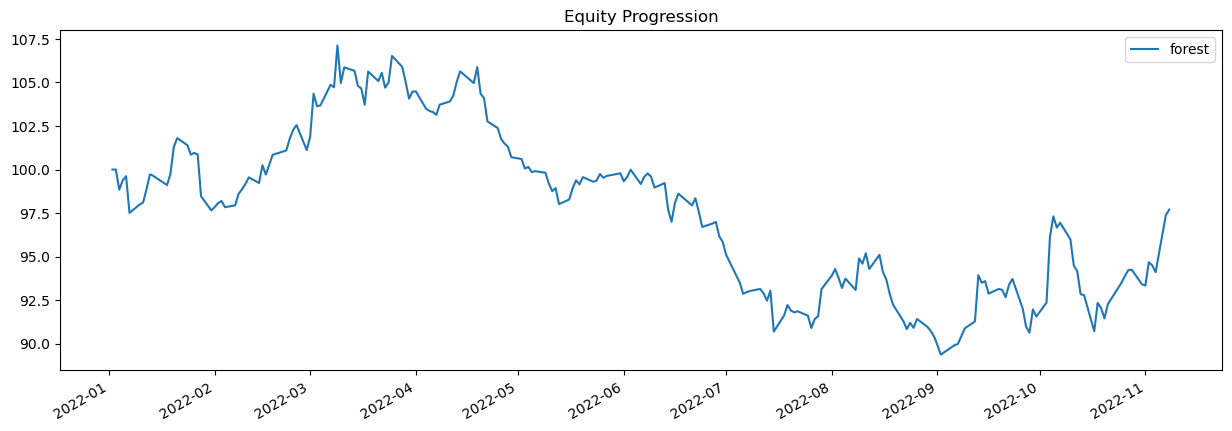

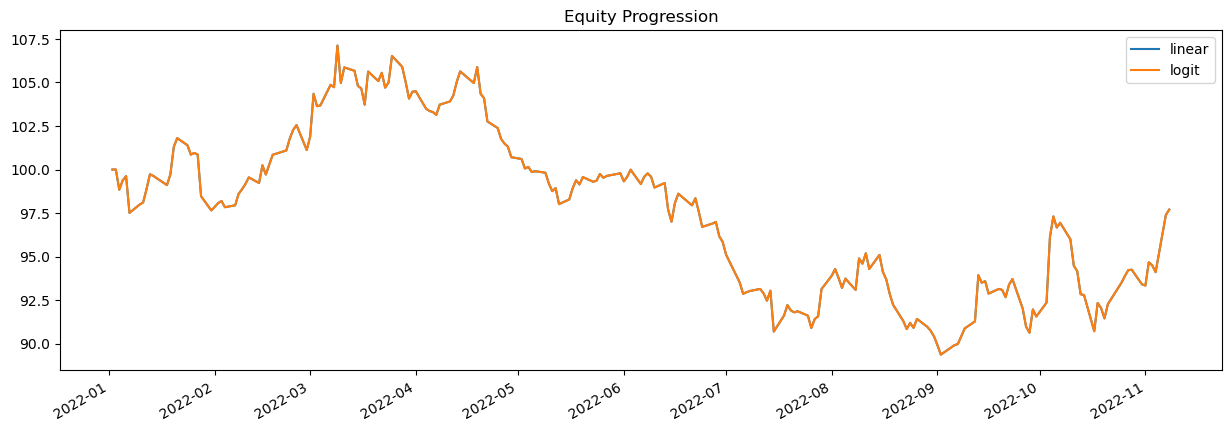

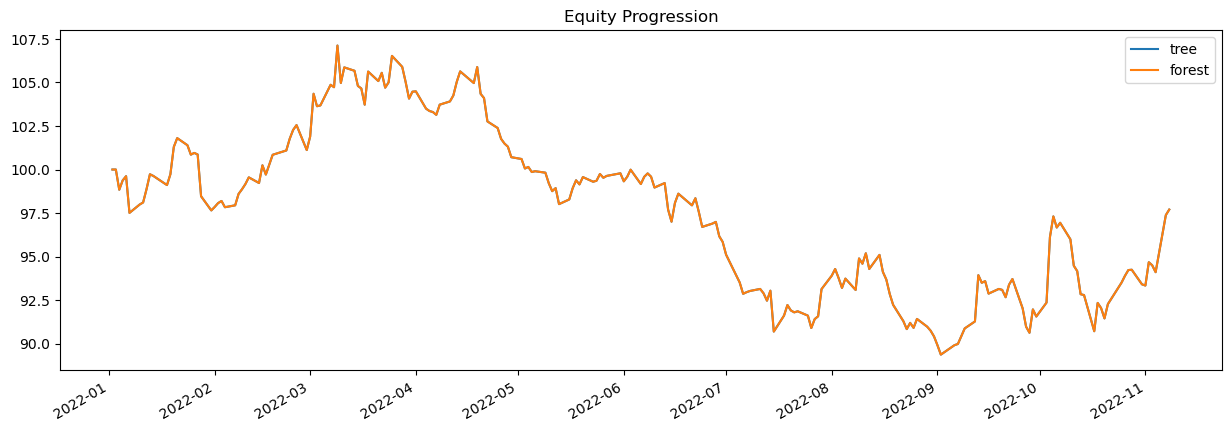

In [2473]:
algo_stack_out = [SelectWhere(signal_outsample), bt.algos.WeighEqually(), bt.algos.Rebalance()]
strategy_tree_out = bt.Strategy('tree', algo_stack_out)
bt_instance_tree_out = bt.Backtest(strategy_tree_out, close_outsamp_df)
res_tree_out = bt.run(bt_instance_tree_out)
res_tree_out.plot()

strategy_forest_out = bt.Strategy('forest', algo_stack_out)
bt_instance_forest_out = bt.Backtest(strategy_forest_out, close_outsamp_df)
res_forest_out = bt.run(bt_instance_forest_out)
res_forest_out.plot()

#linear
strategy_ols_out = bt.Strategy('linear', algo_stack_out)
bt_instance_ols_out = bt.Backtest(strategy_ols_out, close_outsamp_df)
res_ols_out = bt.run(bt_instance_ols_out)

#logit
strategy_logit_out = bt.Strategy('logit', algo_stack_out)
bt_instance_logit_out = bt.Backtest(strategy_logit_out, close_outsamp_df)
res_logit_out = bt.run(bt_instance_logit_out)

res_ols_logit_out = bt.run(bt_instance_ols_out, bt_instance_logit_out)
res_ols_logit_out.plot()

res_tree_forest_out = bt.run(bt_instance_tree_out, bt_instance_forest_out)
res_tree_forest_out.plot()


In [2457]:
stats = pd.DataFrame(res_tree_out.stats)

stats['random'] = res_forest_out.stats
stats['linear'] = res_ols_out.stats
stats['logit'] = res_logit_out.stats

In [2458]:
stats.head()

,tree,random,linear,logit
start,2022-01-02 00:00:00,2022-01-02 00:00:00,2022-01-02 00:00:00,2022-01-02 00:00:00
end,2022-11-08 00:00:00,2022-11-08 00:00:00,2022-11-08 00:00:00,2022-11-08 00:00:00
rf,0.0,0.0,0.0,0.0
total_return,-0.022989,-0.022989,-0.022989,-0.022989
cagr,-0.02703,-0.02703,-0.02703,-0.02703


#### 2.2.2 Please interpret your result and compare it to the corresponding in-sample backtesting results. 

Outsample and insample on all same methods. Outsample seems to do better than insample. Although there is a dip starting on April 2022. Then it continues to decrease and stays pretty much volatile throughout. Whereas, insample seems to be more volatile as we can see by sudden dips and sudden ups. 

<span style="color:purple; font-size:30px">
    <b>3. One more thing... </b>
</span> 

#### In this short excercise you have had the opportunity to try to build a simple trading system.  Please describe what you see as the major challenges you encountered and what, if anything, you might do to address them (2-3 paragraphs only, please).

One of the major challenges of building a trading system is that it's very hard to build a good trading system. Prices can get erratic and things can get unpredictable. One of the great things about backtesting is that it allows us to apply our ideas to historical data of the market. 

One of the major challenges I encountered was building a backtesting system. This was challenging because I don't have the experience. But also, the model didn't perform as well as I wanted it to. If I could improve this model, I could do feature selection which can help reduce multicollinarity. 

<span style="color:purple; font-size:30px">
    <b>Extra Credit* (not required)</b>
</span> 

### By leveraging what you've learned in HW01, can you build a model that leads to a strategy that performs better in backtesting than this model? Write a paragraph to explain your results. 

In [2459]:
#building tree model 
X_train_extra = train1[['Log_Return_L01d', 'return_vol_5_L01d',
                       'return_vol_10_L01d', 'return_vol_20_L01d', 'return_vol_30_L01d',
                       'return_vol_60_L01d', 'return_vol_120_L01d', 'macdsingal_L01d', 'macdhist_L01d', 
                       'macdsingal_L01d', 'macdhist_L01d']]
Y_train_extra = train1["positive_return_dummy"]

X_test_extra =  test[['Log_Return_L01d', 'return_vol_5_L01d',
                       'return_vol_10_L01d', 'return_vol_20_L01d', 'return_vol_30_L01d',
                       'return_vol_60_L01d', 'return_vol_120_L01d', 'macdsingal_L01d', 'macdhist_L01d', 
                       'macdsingal_L01d', 'macdhist_L01d']]
Y_test_extra = test["positive_return_dummy"]

X_val_extra = val[['Log_Return_L01d', 'return_vol_5_L01d',
                       'return_vol_10_L01d', 'return_vol_20_L01d', 'return_vol_30_L01d',
                       'return_vol_60_L01d', 'return_vol_120_L01d', 'macdsingal_L01d', 'macdhist_L01d', 
                       'macdsingal_L01d', 'macdhist_L01d']]
Y_val_extra = val['positive_return_dummy']

In [2460]:
tree = DecisionTreeClassifier(max_depth=6, random_state=0, min_samples_leaf=5)
tree.fit(X_train_extra, Y_train_extra)

y_pred1 = tree.predict(X_val_extra)
insamp_ec_res = pd.DataFrame({'real': Y_val_extra, 'pred': y_pred1})
y_pred_test = random.predict(X_test_extra)
outsamp_ec_res = pd.DataFrame({'real': Y_test_extra, 'pred': y_pred_test})

In [2475]:
fpr, tpr, thresholds = metrics.roc_curve(insamp_ec_res['real'], insamp_ec_res['pred'])
print('In Sample AUC:', metrics.auc(fpr, tpr))

#out-of-sample
fpr, tpr, thresholds = metrics.roc_curve(outsamp_ec_res['real'], outsamp_ec_res['pred'])
print('Out of Sample AUC:', metrics.auc(fpr, tpr))


In-Sample AUC: 0.5398126463700234
Out-of-Sample AUC: 0.5066632052613361


In [2462]:

signal_insamp_extra = pd.DataFrame({'extra_tree': np.where(y_pred1 > 0.5, 1, 0), 'extra_tree1': np.where(y_pred1 > 0.5, 1, 0)})
signal_insamp_extra['Date'] = np.append(val['Date_L01d'].dt.date.astype(str).values[1:], last_date_val)
signal_insamp_extra['Date'] = pd.to_datetime(signal_insamp_extra['Date'])
signal_insamp_extra.set_index('Date', inplace=True)
close_insamp_extra = pd.DataFrame({'extra_tree': val['Close_L01d'], 'extra_tree1': val['Close_L01d']})
close_insamp_extra['Date'] = np.append(val['Date_L01d'].dt.date.astype(str).values[1:], last_date_val)
close_insamp_extra['Date'] = pd.to_datetime(close_insamp_extra['Date'])
close_insamp_extra.set_index('Date', inplace=True)


In [2463]:

signal_outsamp_extra = pd.DataFrame({'extra_tree': np.where(y_pred_test > 0.5, 1, 0), 'extra_tree1': np.where(y_pred_test > 0.5, 1, 0)})
signal_outsamp_extra['Date'] = np.append(test['Date_L01d'].dt.date.astype(str).values[1:], last_date)
signal_outsamp_extra['Date'] = pd.to_datetime(signal_outsamp_extra['Date'])
signal_outsamp_extra.set_index('Date', inplace=True)
close_outsamp_extra = pd.DataFrame({'extra_tree': test['Close_L01d'], 'extra_tree1': test['Close_L01d']})
close_outsamp_extra['Date'] = np.append(test['Date_L01d'].dt.date.astype(str).values[1:], last_date)
close_outsamp_extra['Date'] = pd.to_datetime(close_outsamp_extra['Date'])



In-Sample Backtest Results


,Extra_Decision_Tree
start,2021-07-07 00:00:00
end,2022-11-07 00:00:00
rf,0.0
total_return,-0.056871
cagr,-0.042877
max_drawdown,-0.095831
calmar,-0.447428
mtd,NaN
three_month,0.004418
six_month,0.004418


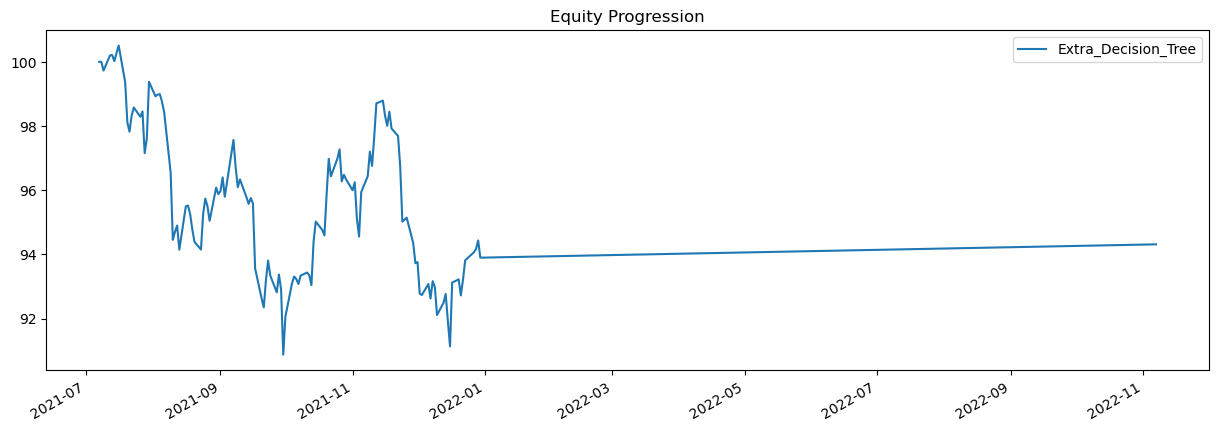

In [2474]:
algo_stack_extra = [SelectWhere(signal_insamp_extra), bt.algos.WeighEqually(), bt.algos.Rebalance()]
strategy_tree_extra = bt.Strategy('Extra_Decision_Tree', algo_stack_extra)
bt_instance_extra = bt.Backtest(strategy_tree_extra, close_insamp_extra)
res_extra = bt.run(bt_instance_extra)
print('In-Sample Backtest Results')
res_extra.plot()
res_extra.stats

I suspect there was multicollinearity before the extra credit ones. This one reduces multicollinearity. 